In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib
import matplotlib.ticker as ticker
from pymcaspec import specfile
import matplotlib as mpl
import lmfit
import matplotlib.colors as col
import matplotlib.cm as cm
from ase.io import read
import copy
import matplotlib.patches as patches
import colorsys
from PIL import Image


mpl.rc('lines', markersize=4)
colors = [f'C{i}' for i in range(10)]
font = {'size' : 7}
matplotlib.rc('font', **font)

# Scan information, and zero offsets
f = specfile('./Online_analysis_20220917_CrSBr_5_Tdep_00_dir.spec')
datafolder = './Online_analysis_20220917_CrSBr_5_Tdep_00_dir.spec'

scanlist = range(119, 125+1)
temps = np.array([30, 70, 110, 130, 140, 150, 200])
xshifts = np.array([0.0018982715185643412,
 0.005365763290116252,
 0.007077931247525938,
 0.0055429216857471675,
 0.005058594172309072,
 0.004369438299143994,
 0.0053165988818608245])

In [6]:
# Some function definitions

def gen_cmap(N, cmap = 'seismic'):
    color_norm = col.Normalize(vmin = 0, vmax = N-1)
    scalar_map = cm.ScalarMappable(norm = color_norm, cmap = cmap)
    def map_index_to_rgb(index):
        return scalar_map.to_rgba(index, 1)
    return map_index_to_rgb
cmap = gen_cmap(len(scanlist), cmap = 'coolwarm')

def rixsDataReader(data_folder, scan, spectrum_name='SPC', xshift = 0, interp=False, x_ref=None, scale = 1, norm=False, 
                   monitor_name='Mirror current / 1e6'): 
    f = specfile(data_folder)
    s = f[scan]
    x = -s['Energy (eV)'][::-1]
    y = s[spectrum_name][::-1]
    
    x = x + xshift
    yerr = np.sqrt(y)

    if interp and isinstance(x_ref, (list, np.ndarray)):
        y = np.interp(x_ref,x,y)
        yerr = np.sqrt(y)
        x = x_ref
    
    if norm:
        norm_factor = s[monitor_name][::-1]
        y = y / norm_factor
        yerr = yerr / norm_factor
        
    y = y * scale
    yerr = yerr * scale
    return x, y, yerr

def mybin(x,y,yerr, binsize):
    new_x = []
    new_y = []
    new_yerr = []
    index = len(x)
    for i in range(0,index, binsize): #n is index, i is value      
        new_x.append(np.mean(x[i:i+binsize]))
        new_y.append(np.mean(y[i:i+binsize]))
        new_yerr.append(np.sqrt(np.mean(yerr[i:i+binsize]**2)))  
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_yerr = np.array(new_yerr)
    
    return new_x, new_y, new_yerr

def gradient_fill(x, y, fill_color='k', ax=None, zfunc=None, alpha=1, zorder=1, reverse=False, **kwargs):
    if ax is None:
        ax = plt.gca()

    if zfunc is None:
        h, w = 100, 1
        z = np.empty((h, w, 4), dtype=float)
        rgb = col.colorConverter.to_rgb(fill_color)
        z[:,:,:3] = rgb
        
        if reverse:
            z[:,:,-1] = np.linspace(alpha, 0.2, h)[:,None]
        else:
            z[:,:,-1] = np.linspace(0.2, alpha, h)[:,None]
    else:
        z = zfunc(x, y, fill_color=fill_color, alpha=alpha)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = patches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    ax.autoscale(True)
    return im

# Function to run the fit for individual scans
def fit_exciton(index, offset, ax, fit_model, params, yoff, color, temp, marker, cen_ex=0, twopeaks=0):
    
    # Import the data
    scan = scanlist[index]
    s = f[scan]
    K = s.get_baseline('H')
    x0,y0,yerr = rixsDataReader(datafolder, scan, xshift=offset , norm=True)  
    x0,y0,yerr = mybin(x0, y0, yerr, 4)
    norm = np.average(s['Mirror current / 1e6'][::-1])/5400

    # Select the data range
    llim = 1.2
    ulim = 2.8
    lower_lim = np.argmax(x0>llim)
    upper_lim = np.argmax(x0>ulim)
    x = x0[lower_lim:upper_lim]
    y = y0[lower_lim:upper_lim]
    x_eval = np.linspace(x.min(), x.max(), 1000)

    # Build the model 
    fit_model2 = copy.deepcopy(fit_model1)
    if twopeaks:
        fit_model2 += lmfit.models.GaussianModel(prefix='ex1_')

    # Initialize the parameters
    params2 = fit_model2.make_params()
    for key in params.keys():
        params2[key].set(value= params[key].value)
    if cen_ex:
        params2['ex_center'].set(value=cen_ex)
    params2['dd0_center'].set(value=1.59, vary=False)
    params2['dd1_center'].set(value=1.723, vary=False)
    params2['dd2_center'].set(value=1.893, vary=False)
    params2['dd3_center'].set(value=2.2, vary=False)
    params2['ex_center'].set(value=1.4, vary=False)
    params2['poly_c0'].set(value=0, vary=False)
    params2['poly_c3'].set(value=0, vary=False)
       
    # Run the fit
    result2 = fit_model2.fit(y, x=x, params=params2)
    params2 = result2.params
    if not result2.success:
        raise Exception("Fail on K={}".format(K))
    
    comps = result2.eval_components(x=x_eval)
    firstone = 1
    for key, y_eval in comps.items():
        if firstone:
            firstone = 0
            yexc = norm*y_eval
            ymod = np.zeros(len(y_eval))
        else:
            ymod += norm*y_eval
    ax.fill_between(x_eval, yexc+ymod+yoff, ymod+yoff, color='r', alpha=0.4)

    x1, y1, y1err = mybin(x0, y0, yerr, 2)
    llim = 1.2
    ulim = 2.8
    lower_lim = np.argmax(x1>llim)
    upper_lim = np.argmax(x1>ulim)
    x1 = x1[lower_lim:upper_lim]
    y1 = y1[lower_lim:upper_lim]
    y1err = y1err[lower_lim:upper_lim]
    h, l, s = colorsys.rgb_to_hls(*color[:3])
    darkcolor = colorsys.hls_to_rgb(h, min(1, l * 0.9), s = s)
    
    ax.errorbar(x1, norm*y1+yoff, norm*y1err, marker=marker, color=darkcolor, label=str(temp)+'K', markersize=4, ls='None', markerfacecolor=(darkcolor[0], darkcolor[1], darkcolor[2], 0.5) )
    ax.plot(x_eval, norm*fit_model2.eval(params2, x=x_eval) +yoff, color=color)
    ax.text( 2.37, yoff+0.011-index*0.0003, str(temp)+' K')

    return params2


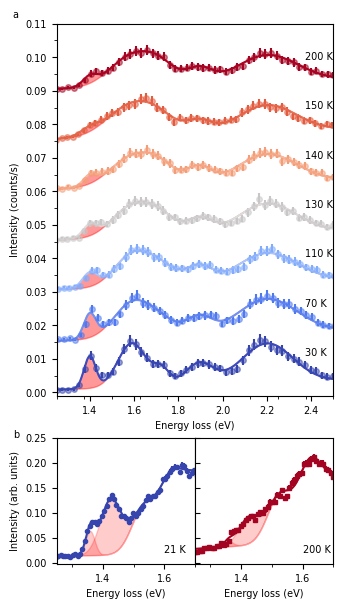

In [7]:
# Fit the low temperature data
# Read in the data
index = 0
scan = scanlist[index]
s = f[scan]
x0,y0,yerr = rixsDataReader(datafolder, scan, xshift=xshifts[index] , norm=True)  
x0,y0,yerr = mybin(x0, y0, yerr, 4)
norm = np.average(s['Mirror current / 1e6'][::-1])/5400

    
# Select the data range
llim = 1.2
ulim = 2.8
lower_lim = np.argmax(x0>llim)
upper_lim = np.argmax(x0>ulim)
x = x0[lower_lim:upper_lim]
y = y0[lower_lim:upper_lim]
x_eval = np.linspace(x.min(), x.max(), 1000)

# Build the model 
def model_bg(x, c0, c1, c2, c3):
    y = c0 + c1*x + c2*x**2 + c3*x**3
    y = np.clip(y, 0, 1e9)
    return y
fit_model1 = lmfit.models.GaussianModel(prefix='ex_') + lmfit.Model(model_bg, prefix='poly_')
fit_model1 += lmfit.models.GaussianModel(prefix='dd0_')
fit_model1 += lmfit.models.GaussianModel(prefix='dd1_')
fit_model1 += lmfit.models.GaussianModel(prefix='dd2_')
fit_model1 += lmfit.models.GaussianModel(prefix='dd3_')


# Initialize the parameters
params1 = fit_model1.make_params()
params1['ex_amplitude'].set(value=.0005, vary=True)
params1['ex_center'].set(value=1.4, vary=True)
params1['ex_sigma'].set(value=0.03, vary=True)
params1['dd0_amplitude'].set(value=.0015, vary=True)
params1['dd0_center'].set(value=1.6, vary=True)
params1['dd0_sigma'].set(value=0.04, vary=True)
params1['dd1_amplitude'].set(value=.0007*norm, vary=True)
params1['dd1_center'].set(value=1.72, vary=True)
params1['dd1_sigma'].set(value=0.04, vary=True)
params1['dd2_amplitude'].set(value=.0008, vary=True)
params1['dd2_center'].set(value=1.9, vary=True)
params1['dd2_sigma'].set(value=0.04, vary=True)
params1['dd3_amplitude'].set(value=.002, vary=True)
params1['dd3_center'].set(value=2.23, vary=True)
params1['dd3_sigma'].set(value=0.08, vary=True)
params1['poly_c0'].set(value=0, vary=False)
params1['poly_c1'].set(value=0, vary=True)
params1['poly_c2'].set(value=0, vary=True)
params1['poly_c3'].set(value=0, vary=False)

# Run the fit
result1 = fit_model1.fit(y, x=x, params=params1)
params1 = result1.params
if not result1.success:
    raise Exception("Fail on K={}".format(K))

fig = plt.figure(figsize=((3+3/8), 6))
ax = fig.add_axes([0.15,0.35,0.82,0.62])
ax1a = fig.add_axes([0.15,0.07,0.41,0.21])
ax1b = fig.add_axes([0.15+0.41,0.07,0.41,0.21])

parlist = []
exciton_centers = np.zeros(7)
twopeaks_arr = np.zeros(7)
cen_ex = np.zeros(7)

markers = ['o']*7
for index, key in enumerate(scanlist):
    offset = xshifts[index]
    if index==0:
        tt=params1
    else:
        tt=params2
    yoff = 0.016*index*6323/5400
    yoff = 0.015*index
    temp = temps[index]
    params2 = fit_exciton(index, offset, ax, fit_model1, tt, yoff, cmap(index), temp, markers[index], cen_ex=exciton_centers[index], twopeaks=twopeaks_arr[index] ) 
    parlist.append(params2)
    
ax.set_xlim(1.25, 2.5)
ax.set_ylim(-0.001, 0.11)
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('Intensity (counts/s)')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.125))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))

import h5py
f = h5py.File('./six-236750_236758.hdf', 'r') #low T
evals = np.ravel(f['data']['E'][:])
time = f['meta/total_time'][()].sum()
count_sec = f['data/rixs'][()]
counts = count_sec[:, 0]*time
color = cmap(0)
h, l, s = colorsys.rgb_to_hls(*color[:3])
darkcolor = colorsys.hls_to_rgb(h, min(1, l * 0.9), s = s)
ax1a.errorbar(evals/1000, counts/time, counts**0.5/time, marker='o', color=darkcolor, markersize=3, ls='None' , label='21 K')
fitdat = np.genfromtxt('./lowtfit')
ax1a.plot(fitdat[:, 0], fitdat[:, 1:].sum(axis=1)/time, color=darkcolor)
ax1a.fill_between(fitdat[:, 0], (fitdat[:, 1]+fitdat[:, 3])/time, fitdat[:, 3]/time, color='r', alpha=0.2)
ax1a.fill_between(fitdat[:, 0], (fitdat[:, 2]+fitdat[:, 3])/time, fitdat[:, 3]/time, color='r', alpha=0.2)

f = h5py.File('./six-239331_239336.hdf', 'r') #high T
evals = np.ravel(f['data']['E'][:])
time = f['meta/total_time'][()].sum()
count_sec = f['data/rixs'][()]
counts = count_sec[:, 0]*time
color = cmap(6)
h, l, s = colorsys.rgb_to_hls(*color[:3])
darkcolor = colorsys.hls_to_rgb(h, min(1, l * 0.9), s = s)
ax1b.errorbar(evals/1000, counts/time, counts**0.5/time, marker='s', color=darkcolor, markersize=3, ls='None', label='200 K' )
fitdat = np.genfromtxt('./hightfit')
ax1b.plot(fitdat[:, 0], fitdat[:, 1:].sum(axis=1)/time, color=darkcolor)
ax1b.fill_between(fitdat[:, 0], (fitdat[:, 1]+fitdat[:, 3])/time, fitdat[:, 3]/time, color='r', alpha=0.2)
ax1b.fill_between(fitdat[:, 0], (fitdat[:, 2]+fitdat[:, 3])/time, fitdat[:, 3]/time, color='r', alpha=0.2)

ax1a.set_xlabel('Energy loss (eV)')
ax1a.set_ylabel('Intensity (arb. units)')
ax1a.set_xlim(1.25, 1.7)
ax1a.set_ylim(-0.001, 0.25)
ax1a.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1a.text(1.6, 0.02, '21 K')

ax1b.set_xlabel('Energy loss (eV)')
ax1b.set_xlim(1.25, 1.7)
ax1b.set_ylim(-0.001, 0.25)
ax1b.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1b.set_yticklabels([])
ax1b.tick_params(axis='y', direction='in',  which='both')
ax1b.text(1.6, 0.02, '200 K')

fig.text(0.02, 0.98, 'a')
fig.text(0.02, 0.28, 'b')
plt.show()